In [16]:
import pandas as pd
import numpy as np
import datetime as dt
import nltk, warnings
import itertools
from statistics import mean
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.neighbors import LocalOutlierFactor
from numpy import where
import calendar

year_n=pd.read_csv('data_for_clustering.csv')

In [17]:
year_n.columns=['0','client_id', 'date', 'check_id', 'month', 'revenue']
year_n.head()

,0,client_id,date,check_id,month,revenue
0,0,644474c3d41185fa4c4f427095954f06,2019-10-17,f0478c7f392532b5b9843e144a31cb78,10,902.36004
1,9,644474c3d41185fa4c4f427095954f06,2019-10-23,1b8a2909d5afdb9170e13b13ed085c0d,10,328.00000
2,15,644474c3d41185fa4c4f427095954f06,2019-05-04,916cdb7b2ee9a9e7fce3947a7c7080df,5,442.78268
3,23,644474c3d41185fa4c4f427095954f06,2019-10-21,1b6dd98eb9f2b4cde778ad3daff4a7ee,10,512.78000
4,29,644474c3d41185fa4c4f427095954f06,2019-11-18,87480360929d774f2770538257bc54df,11,339.00000


In [18]:
#choose time period, get weeks and remove incomplete weeks
year_n['date'] = pd.to_datetime(year_n['date'])
year_copy=year_n[(year_n['date']>=dt.datetime(2019,9,1)) & (year_n['date']<dt.datetime(2020,9,1))]
year_copy['week']=[i.isocalendar()[1] for i in year_copy['date']] #adding weeks

condition = year_copy['date'] >= dt.datetime(2019, 12, 30)
year_copy.loc[condition, 'week'] = year_copy.loc[condition, 'week'].apply(lambda x: x + 52 if 1 <= x <= 36 else x)
year_copy = year_copy[(year_copy['week']>35) & (year_copy['week']<88)]
year_copy['week'] = year_copy['week'] - 35 #make an order of weeks from 1
year_copy.head()

<ipython-input-18-c3f6eb99bc50>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  year_copy['week']=[i.isocalendar()[1] for i in year_copy['date']] #adding weeks
<ipython-input-18-c3f6eb99bc50>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  year_copy['week'] = year_copy['week'] - 35 #make an order of weeks from 1


,0,client_id,date,check_id,month,revenue,week
0,0,644474c3d41185fa4c4f427095954f06,2019-10-17,f0478c7f392532b5b9843e144a31cb78,10,902.36004,7
1,9,644474c3d41185fa4c4f427095954f06,2019-10-23,1b8a2909d5afdb9170e13b13ed085c0d,10,328.00000,8
3,23,644474c3d41185fa4c4f427095954f06,2019-10-21,1b6dd98eb9f2b4cde778ad3daff4a7ee,10,512.78000,8
4,29,644474c3d41185fa4c4f427095954f06,2019-11-18,87480360929d774f2770538257bc54df,11,339.00000,12
5,33,644474c3d41185fa4c4f427095954f06,2019-10-27,5d498fbcf020098dd4a10b9ec6f55e42,10,2151.46916,8


In [19]:
#check that all weeks are full
year_copy.groupby(['week'])['date'].nunique().mean()

7.0

In [65]:
#defining function for giving names to our future clusters
def create_names(grouped,i=3):
  s=grouped.T.to_dict('list')
  new_s={}
  if week<90:
    for keys, values in s.items():
      if ((values[0]==grouped[f'Frequency{str(week)}'].min()) & (values[1]==grouped[f'Monetary{str(week)}'].min())) == True:
        new_s['sleeping'] = keys
      elif values[1] == np.sort(grouped[f'Monetary{str(week)}'].to_list())[1]:
        new_s['loyal'] = keys
      elif values[1] == np.sort(grouped[f'Monetary{str(week)}'].to_list())[2]:
        new_s['champions'] = keys
  news=pd.DataFrame.from_dict(new_s, orient='index')
  news=news.reset_index()
  news.columns = [f'name{str(week)}',f'cluster{str(week)}']
  return news

In [77]:
#getting metrics FM for the 1st week
year_copy1 = year_copy[['client_id', 'check_id', 'revenue', 'date', 'week']]
year1=year_copy1[year_copy1['week'] == 1]

frequency_df = year1.groupby(by=['client_id'], as_index=False)['check_id'].nunique()
frequency_df.columns = ['client_id','Frequency1']
monetary_df = year1.groupby(by='client_id',as_index=False).agg({'revenue': 'sum'})
monetary_df.columns = ['client_id','Monetary1']
fm_df = frequency_df.merge(monetary_df,on='client_id')

rfm_cl=fm_df[['client_id','Monetary1']]

In [43]:
rfm_cl.head()

,client_id,Monetary1
0,00125fe3b05ba65e08e6727837059786,35.0000
1,00157fd1a5d51498f4f6b163341ba789,157.0000
2,001ff3e3c3fe8ac01c5e8af8129e93fb,114.0000
3,0025e578789f9f29a97b4f33c4edaa78,1119.1276
4,0035493aea0f02271c7204e02af85d6c,338.9800


In [ ]:
#getting metrics FM and clustering in each period
year_copy1 = year_copy[['client_id', 'check_id', 'revenue', 'date', 'week']]
dates=list(set(year_copy1['week'].to_list()))

silhouette_list = []

for week in dates:
  year1=year_copy1[year_copy1['week'] == week] #choosing period

  frequency_df = year1.groupby(by=['client_id'], as_index=False)['check_id'].nunique() #get frequency
  frequency_df.columns = ['client_id',f'Frequency{str(week)}']
  monetary_df = year1.groupby(by='client_id',as_index=False).agg({'revenue': 'sum'}) #get monetary
  monetary_df.columns = ['client_id',f'Monetary{str(week)}']
  fm_df = frequency_df.merge(monetary_df,on='client_id')
  #print(fm_df)

  scaler = StandardScaler() #normalizining FM metrics
  rfm_normalised = fm_df[[f'Frequency{str(week)}',f'Monetary{str(week)}']]
  scaler.fit(rfm_normalised)
  scaled_matrix = scaler.transform(rfm_normalised)
  scaled_matrix=pd.DataFrame(scaled_matrix)

  kmeans = KMeans(init='k-means++', n_clusters = 3, max_iter=100) #clustering using K-means
  kmeans.fit(scaled_matrix)
  cluster_lables=kmeans.labels_
  silhouette_avg = silhouette_score(scaled_matrix, cluster_lables) #to define quality of clustering
  silhouette_list.append(silhouette_avg)

  scaled_matrix.loc[:,'client_id']=fm_df['client_id']
  scaled_matrix[f'cluster{str(week)}']=kmeans.labels_
  clusters=fm_df.merge(scaled_matrix[['client_id',f'cluster{str(week)}']], on='client_id')
  grouped=clusters[[f'cluster{str(week)}', f'Frequency{str(week)}',f'Monetary{str(week)}']].groupby([f'cluster{str(week)}']).mean()

  news=create_names(grouped, i={str(week)}) #using our function to define names of clusters
  clusters1=clusters.merge(news, on=f'cluster{str(week)}', how='left')
  rfm_cl=rfm_cl.merge(clusters1[['client_id',f'name{str(week)}']], on='client_id', how='outer')


In [25]:
print(mean(silhouette_list))

0.5989540142166891


In [80]:
rfm_cl=rfm_cl.drop(['Monetary1'], axis=1)
rfm_cl.head()

,client_id,name1,name2,name3,name4,name5,name6,name7,name8,name9,...,name43,name44,name45,name46,name47,name48,name49,name50,name51,name52
0,00125fe3b05ba65e08e6727837059786,sleeping,sleeping,sleeping,sleeping,sleeping,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,sleeping
1,00157fd1a5d51498f4f6b163341ba789,sleeping,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,001ff3e3c3fe8ac01c5e8af8129e93fb,sleeping,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,sleeping,NaN,NaN,NaN,sleeping,NaN,NaN,NaN,NaN,NaN
3,0025e578789f9f29a97b4f33c4edaa78,sleeping,NaN,loyal,sleeping,NaN,sleeping,sleeping,NaN,NaN,...,sleeping,loyal,sleeping,sleeping,loyal,sleeping,loyal,loyal,sleeping,sleeping
4,0035493aea0f02271c7204e02af85d6c,sleeping,loyal,loyal,loyal,sleeping,sleeping,loyal,loyal,sleeping,...,NaN,sleeping,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [81]:
rfm_cl.to_csv('clusters_for_52weeks.csv')

In [ ]:
#clustering for all periods and combining results with metrics into 1 dataset
year_copy1 = year_copy[['client_id', 'check_id', 'revenue', 'date', 'week']]
dates=list(set(year_copy1['week'].to_list()))

for week in dates:
  year1=year_copy1[year_copy1['week'] == week] #choosing period

  frequency_df = year1.groupby(by=['client_id'], as_index=False)['check_id'].nunique() #get frequency
  frequency_df.columns = ['client_id',f'Frequency{str(week)}']
  monetary_df = year1.groupby(by='client_id',as_index=False).agg({'revenue': 'sum'}) #get monetary
  monetary_df.columns = ['client_id',f'Monetary{str(week)}']
  fm_df = frequency_df.merge(monetary_df,on='client_id')
  #print(fm_df)

  scaler = StandardScaler() #normalizining FM metrics
  rfm_normalised = fm_df[[f'Frequency{str(week)}',f'Monetary{str(week)}']]
  scaler.fit(rfm_normalised)
  scaled_matrix = scaler.transform(rfm_normalised)
  scaled_matrix=pd.DataFrame(scaled_matrix)

  kmeans = KMeans(init='k-means++', n_clusters = 3, max_iter=100) #clustering using K-means
  kmeans.fit(scaled_matrix)
  cluster_lables=kmeans.labels_
  silhouette_avg = silhouette_score(scaled_matrix, cluster_lables) #to define quality of clustering
  silhouette_list.append(silhouette_avg)

  scaled_matrix.loc[:,'client_id']=fm_df['client_id']
  scaled_matrix[f'cluster{str(week)}']=kmeans.labels_
  clusters=fm_df.merge(scaled_matrix[['client_id',f'cluster{str(week)}']], on='client_id')
  grouped=clusters[[f'cluster{str(week)}', f'Frequency{str(week)}',f'Monetary{str(week)}']].groupby([f'cluster{str(week)}']).mean()

  news=create_names(grouped, i={str(week)}) #using our function to define names of clusters
  clusters1=clusters.merge(news, on=f'cluster{str(week)}', how='left')
  rfm_cl=rfm_cl.merge(clusters1[['client_id',f'name{str(week)}', f'Frequency{str(week)}',f'Monetary{str(week)}']], on='client_id', how='outer')

rfm_cl.to_csv('clusters_52_weeks_with_metrics.csv')

In [68]:
df_cust = pd.read_csv('clusters_52_weeks_with_metrics.csv')

<ipython-input-68-d7f2f3ef5c69>:1: DtypeWarning: Columns (3,6,9,12,15,18,21,24,27,30,33,36,39,42,45,48,51,54,57,60,63,66,69,72,75,78) have mixed types. Specify dtype option on import or set low_memory=False.
  df_cust = pd.read_csv('clusters_52_weeks_with_metrics.csv')


In [61]:
df_cust.head()

,Unnamed: 0,client_id,Monetary1_x,name1,Frequency1,Monetary1_y,name2,Frequency2,Monetary2,name3,...,Monetary49,name50,Frequency50,Monetary50,name51,Frequency51,Monetary51,name52,Frequency52,Monetary52
0,0,00125fe3b05ba65e08e6727837059786,35.0000,sleeping,1.0,35.0000,sleeping,1.0,71.00000,sleeping,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,sleeping,2.0,309.0
1,1,00157fd1a5d51498f4f6b163341ba789,157.0000,sleeping,1.0,157.0000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,001ff3e3c3fe8ac01c5e8af8129e93fb,114.0000,sleeping,2.0,114.0000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,0025e578789f9f29a97b4f33c4edaa78,1119.1276,sleeping,2.0,1119.1276,NaN,NaN,NaN,loyal,...,2152.60444,loyal,4.0,2410.388,sleeping,2.0,785.0,sleeping,1.0,154.0
4,4,0035493aea0f02271c7204e02af85d6c,338.9800,sleeping,3.0,338.9800,loyal,5.0,952.47644,loyal,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [69]:
df_cust=df_cust.drop(['Unnamed: 0', 'Monetary1_x'], axis=1)
df_cust.rename(columns={'Monetary1_y': 'Monetary1'}, inplace=True)
df_cust.head()

,client_id,name1,Frequency1,Monetary1,name2,Frequency2,Monetary2,name3,Frequency3,Monetary3,...,Monetary49,name50,Frequency50,Monetary50,name51,Frequency51,Monetary51,name52,Frequency52,Monetary52
0,00125fe3b05ba65e08e6727837059786,sleeping,1.0,35.0000,sleeping,1.0,71.00000,sleeping,3.0,265.00000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,sleeping,2.0,309.0
1,00157fd1a5d51498f4f6b163341ba789,sleeping,1.0,157.0000,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,001ff3e3c3fe8ac01c5e8af8129e93fb,sleeping,2.0,114.0000,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0025e578789f9f29a97b4f33c4edaa78,sleeping,2.0,1119.1276,NaN,NaN,NaN,loyal,5.0,3513.90220,...,2152.60444,loyal,4.0,2410.388,sleeping,2.0,785.0,sleeping,1.0,154.0
4,0035493aea0f02271c7204e02af85d6c,sleeping,3.0,338.9800,loyal,5.0,952.47644,loyal,5.0,2915.01184,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [70]:
#save the output
df_cust.to_csv('customers_with_metrics(52&2).csv')

## Some useful graphs

<ipython-input-71-5f7bd291577c>:3: DtypeWarning: Columns (2,5,8,11,14,17,20,23,26,29,32,35,38,41,44,47,50,53,56,59,62,65,68,71,74,77) have mixed types. Specify dtype option on import or set low_memory=False.
  df_cust = pd.read_csv('customers_with_metrics(52&2).csv')


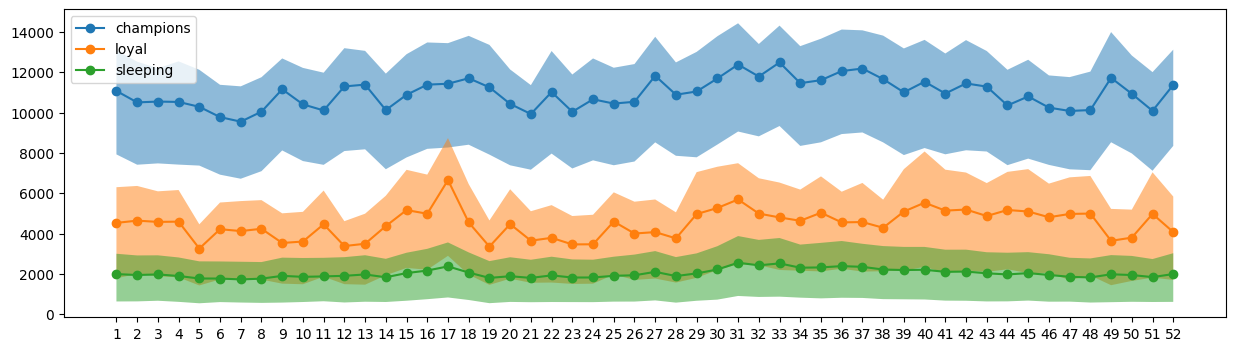

In [71]:
import matplotlib.pyplot as plt

df_cust = pd.read_csv('customers_with_metrics(52&2).csv')

c_mean, c_q25, c_q75, c_sum, l_mean, l_q25, l_q75, l_sum, s_mean, s_q25, s_q75, s_sum = [],[],[],[],[],[],[],[],[],[],[],[]

for period in range(1,53):

    df_temp = df_cust.groupby(by = 'name' + str(period))

    c_mean.append(df_temp[['Monetary' + str(period)]].mean().loc['champions'][0])

    c_q25.append(df_temp[['Monetary' + str(period)]].quantile(q = 0.25).loc['champions'][0])

    c_q75.append(df_temp[['Monetary' + str(period)]].quantile(q = 0.75).loc['champions'][0])

    c_sum.append(df_temp[['Monetary' + str(period)]].sum().loc['champions'][0])

    l_mean.append(df_temp[['Monetary' + str(period)]].mean().loc['loyal'][0])

    l_q25.append(df_temp[['Monetary' + str(period)]].quantile(q = 0.25).loc['loyal'][0])

    l_q75.append(df_temp[['Monetary' + str(period)]].quantile(q = 0.75).loc['loyal'][0])

    l_sum.append(df_temp[['Monetary' + str(period)]].sum().loc['loyal'][0])

    s_mean.append(df_temp[['Monetary' + str(period)]].mean().loc['sleeping'][0])

    s_q25.append(df_temp[['Monetary' + str(period)]].quantile(q = 0.25).loc['sleeping'][0])
    s_q75.append(df_temp[['Monetary' + str(period)]].quantile(q = 0.75).loc['sleeping'][0])

    s_sum.append(df_temp[['Monetary' + str(period)]].sum().loc['sleeping'][0])



m = [x for x in range(1,53)]
fig = plt.figure(figsize = (15,4))
plt.plot(m, c_mean, 'o-', label = 'champions')
plt.fill_between(m, c_q25, c_q75, alpha = 0.5)
plt.plot(m, l_mean, 'o-', label = 'loyal')
plt.fill_between(m, l_q25, l_q75, alpha = 0.5)
plt.plot(m, s_mean, 'o-', label = 'sleeping')
plt.fill_between(m, s_q25, s_q75, alpha = 0.5)
plt.xticks(m)
plt.legend()

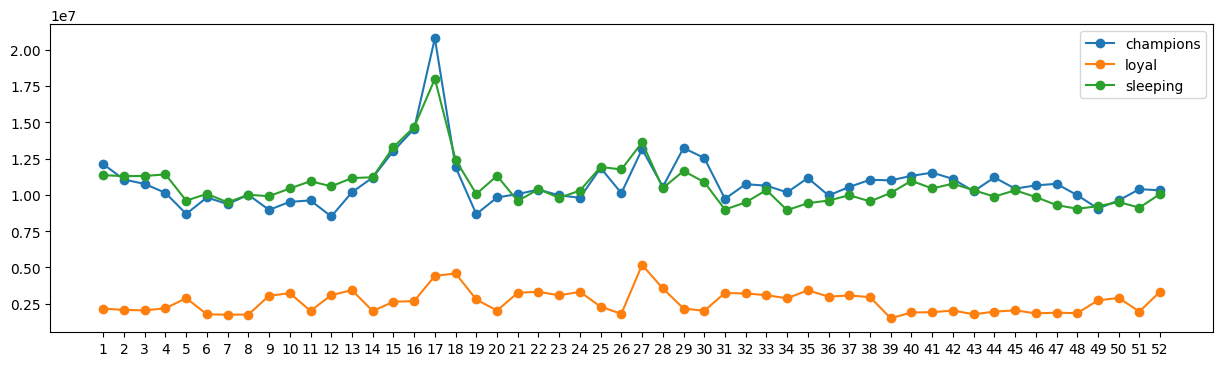

In [72]:
fig = plt.figure(figsize = (15,4))

plt.plot(m, c_sum, 'o-', label = 'champions')

plt.plot(m, l_sum, 'o-', label = 'loyal')

plt.plot(m, s_sum, 'o-', label = 'sleeping')

plt.xticks(m)

plt.legend()